<h3>Importing Packages</h3>

In [266]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import wget
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
#Downloading Pre trained model which is trained on Wekipedia clinical data
wget.download("http://evexdb.org/pmresources/vec-space-models/wikipedia-pubmed-and-PMC-w2v.bin", out="./models/wikipedia-pubmed-and-PMC-w2v.bin")

'./models/wikipedia-pubmed-and-PMC-w2v.bin'

<h3>Loading input data</h3>

In [11]:
df_clinnotes = pd.read_csv("ClinNotes.csv")

In [12]:
df_clinnotes.head(3)

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."


In [64]:
df_clinnotes.shape

(818, 2)

In [13]:
df_medicalconcept = pd.read_csv("MedicalConcepts.csv")

In [14]:
df_medicalconcept.head(3)

,Term1,Term2
0,Glaucoma,Fibrillation
1,Carbatrol,Dilantin
2,Cardiomyopathy,Tylenol


In [10]:
#Load word2vec model using gensim
wv_model = KeyedVectors.load_word2vec_format("./models/wikipedia-pubmed-and-PMC-w2v.bin", binary=True)

In [19]:
wv_model.vector_size

200

<h3>Generate word embedding</h3>

In [15]:
text = "Glaucoma"
wv_model[text]

array([ 0.04206313,  0.09436155,  0.21329673, -0.18971173,  0.23185113,
        0.011357  , -0.08961955, -0.13801372, -0.02668227,  0.05952289,
       -0.546213  , -0.02262211, -0.06904755, -0.21802306,  0.04287683,
        0.32588834, -0.3426749 , -0.15005103,  0.02900226, -0.4323569 ,
       -0.62308407,  0.41513354, -0.13565697,  0.36646917, -0.26050845,
       -0.21263304,  0.14488305,  0.45878547, -0.42721593,  0.19280359,
        0.07390834,  0.09453195,  0.19352588, -0.5283749 , -0.2087875 ,
        0.03499792, -0.45797318,  0.29001543,  0.03232219,  0.09004665,
        0.33195233, -0.0368323 , -0.07705072, -0.16310354,  0.19740424,
        0.00923192,  0.26021326,  0.13754323, -0.01566762, -0.08320232,
       -0.31265512,  0.06645823,  0.10848603, -0.02941357, -0.33300373,
       -0.2190567 , -0.41395426, -0.3639581 , -0.05724086, -0.05246092,
       -0.14339142,  0.38613668,  0.5285088 ,  0.28163972,  0.17605011,
        0.42080587,  0.06293115, -0.0732395 , -0.2436617 ,  0.16

In [40]:
wv_model.index_to_key

['</s>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 ')',
 '(',
 'a',
 'with',
 'was',
 'for',
 'The',
 'is',
 'that',
 'were',
 'by',
 '"',
 'as',
 'on',
 'from',
 'at',
 'are',
 '%',
 'or',
 'be',
 'an',
 'In',
 'not',
 ';',
 'patients',
 'this',
 ':',
 'which',
 "'s",
 'cells',
 'have',
 'has',
 'also',
 'A',
 'between',
 'study',
 'been',
 'it',
 'but',
 'than',
 'after',
 'had',
 'their',
 '1',
 'these',
 '=',
 'two',
 'used',
 'This',
 'can',
 'using',
 'we',
 'may',
 'more',
 'cell',
 'other',
 'one',
 'all',
 '2',
 'his',
 'both',
 'during',
 'data',
 "'",
 'its',
 'treatment',
 'We',
 '[',
 ']',
 'results',
 'into',
 'first',
 'group',
 'expression',
 'time',
 'only',
 'It',
 'analysis',
 'protein',
 'he',
 'no',
 'found',
 'who',
 'activity',
 'different',
 'such',
 '3',
 '<',
 'when',
 'levels',
 'studies',
 'years',
 'most',
 'each',
 'et',
 'disease',
 'control',
 'significant',
 'increased',
 'number',
 'effect',
 'they',
 'high',
 'three',
 'gene',
 'compared',
 'u

<h3>Finding vecorts and cosine similarty of Medical Concept</h3>

In [42]:
list_term1_vec = []
list_term2_vec = []
list_cosine_similarity = []
for index, row in df_medicalconcept.iterrows():
    try:
        vec1 = wv_model[row['Term1']]
        vec2 = wv_model[row['Term2']]
        list_term1_vec.append(vec1)
        list_term2_vec.append(vec2)
        list_cosine_similarity.append(wv_model.similarity(row['Term1'],row['Term2']))
    except KeyError as e:
        #If one of the word does not exists adding out of Vocabulary
        list_term1_vec.append("Out of Vocabulary")
        list_term2_vec.append("Out of Vocabulary")
        list_cosine_similarity.append('NA')
df_medicalconcept['wv_encoding_term1'] = list_term1_vec
df_medicalconcept['wv_encoding_term2'] = list_term2_vec
df_medicalconcept['Cosine_Similarity'] = list_cosine_similarity

In [43]:
df_medicalconcept.head()

,Term1,Term2,wv_encoding_term1,wv_encoding_term2,Cosine_Similarity
0,Glaucoma,Fibrillation,"[0.042063132, 0.09436155, 0.21329673, -0.18971...","[-4.7587626e-05, 0.25418127, -0.015910983, -0....",0.384217
1,Carbatrol,Dilantin,"[-0.045331027, 0.11067079, -0.09558493, -0.090...","[0.012084651, 0.005205608, -0.23301634, 0.1028...",0.547312
2,Cardiomyopathy,Tylenol,"[0.16128881, 0.3240048, 0.33117175, 0.11453397...","[-0.27419475, -0.3183561, -0.14672743, 0.25168...",-0.002026
3,Herpes,Hyperthyroidism,"[0.52553093, -0.03039215, 0.2589976, 0.2131500...","[0.45243922, -0.057198644, 0.062269304, -0.222...",0.227363
4,Seasickness,Nausea,"[-0.016013121, -0.018356817, 0.15857796, -0.11...","[-0.72453856, -0.029742686, -0.26826498, -0.05...",0.240243


In [298]:
df_medicalconcept['Cosine_Similarity'].replace('NA', 0).mean()

0.28387807079594146

In [ ]:
df_medicalconcept.to_csv("medical_concept_similarity.csv", index=False)

### Clean Text

In [285]:
stop_words = stopwords.words('english')
#removing stop words
df_clinnotes['clean_notes'] = df_clinnotes['notes'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in (stop_words)]))
#removing puntuation
df_clinnotes["clean_notes"] = df_clinnotes['clean_notes'].str.replace('[^\w\s]','', regex=True)
#lemetizing the text
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])
df_clinnotes['clean_notes'] = df_clinnotes['clean_notes'].apply(lemmatize_text)

In [230]:
def word_vec(word):
    try:
        vec = wv_model[word]
        return vec
    except KeyError as e:
        return np.zeros(200, dtype = np.float32)

In [276]:
df_clinnotes['sentence_vec'] = 'nan'
for index, row in df_clinnotes.iterrows():
    df_clinnotes['sentence_vec'].iloc[index] = np.mean([word_vec(w) for w in row['clean_notes'].split()], axis=0).ravel()

In [282]:
df_clinnotes.head(2)

,category,notes,clean_notes,sentence_vec
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2D MMODE 1 Left atrial enlargement left atrial...,"[0.11900953, 0.07610129, 0.109805964, 0.023172..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 left ventricular cavity size wall thickness ...,"[0.08709327, 0.040551707, 0.11893561, -0.03157..."


In [251]:
X_train, X_test, y_train, y_test = train_test_split(df_clinnotes.sentence_vec, df_clinnotes.category, test_size=0.2, random_state=42)


In [252]:
X_train[0]

array([ 0.11900953,  0.07610129,  0.10980596,  0.02317212, -0.12414008,
        0.08772073, -0.03461249, -0.0815425 , -0.0399415 ,  0.07863992,
       -0.02563295,  0.04166684,  0.33024472, -0.20867923, -0.13311572,
       -0.11270147, -0.07781155, -0.18316929,  0.21984649, -0.01944642,
        0.02162555,  0.03185833,  0.02968349, -0.00948495, -0.26003337,
        0.04232191, -0.07863817, -0.11295093,  0.0484227 , -0.11017112,
       -0.195218  ,  0.03779848, -0.06330861, -0.20354883,  0.02302869,
       -0.09992291,  0.0181471 ,  0.00836525,  0.16633922,  0.02526055,
       -0.03039892,  0.01292599,  0.12364707,  0.03285488,  0.0536604 ,
        0.09693155,  0.13132903, -0.05141966, -0.12009291,  0.02689553,
        0.03710788,  0.0066507 , -0.06895128,  0.05044799, -0.09005504,
        0.01845573,  0.04556221,  0.06564354,  0.15298787,  0.08501782,
        0.07731491, -0.03560639,  0.08924785, -0.10921634,  0.06362176,
       -0.0879752 ,  0.12681995, -0.00987065, -0.0419999 ,  0.04

In [253]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [260]:
type(X_train.values)

numpy.ndarray

<h3>Performing Cross Validation on Various ML Algorithms</h3>

In [261]:
models = [
    RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=3, min_samples_leaf=2),
    LinearSVC(),
    XGBClassifier(learning_rate =0.07,n_estimators=100),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, np.array(X_train.tolist()), y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [262]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.931298
1,RandomForestClassifier,1,0.954198
2,RandomForestClassifier,2,0.923664
3,RandomForestClassifier,3,0.946565
4,RandomForestClassifier,4,0.900000
5,LinearSVC,0,0.938931
6,LinearSVC,1,0.969466
7,LinearSVC,2,0.946565
8,LinearSVC,3,0.954198
9,LinearSVC,4,0.946154


In [113]:
# function is defined for generating the sentence vector
def sentence_vector(text):
    feature_vec=[]
    words=text.split(" ")
    for w in words:
        try:
            vector=wv_model[w]
            if vector=="nan":
                ("")
            else:
                feature_vec.append(vector)
        except:
            ("")

    final=np.array(feature_vec)
    feature_vec=final.mean(axis=0)
    return feature_vec

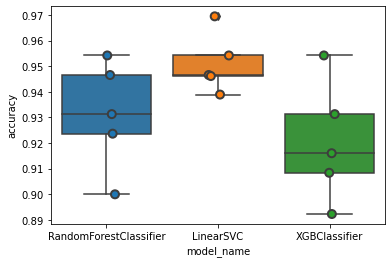

In [267]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [271]:
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=3, min_samples_leaf=2, )
rf_clf.fit(np.array(X_train.tolist()), y_train)
print_score(rf_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=True)
print_score(rf_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=False)

Train Result:
Accuracy Score: 98.93%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology   Neurology  accuracy  \
precision                    0.983278          1.000000    0.988827  0.989297   
recall                       0.996610          0.977778    0.988827  0.989297   
f1-score                     0.989899          0.988764    0.988827  0.989297   
support                    295.000000        180.000000  179.000000  0.989297   

            macro avg  weighted avg  
precision    0.990701      0.989399  
recall       0.987738      0.989297  
f1-score     0.989163      0.989293  
support    654.000000    654.000000  
_______________________________________________
Confusion Matrix: 
 [[294   0   1]
 [  3 176   1]
 [  2   0 177]]

Test Result:
Accuracy Score: 93.29%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology  Neurology  accura

In [283]:
lsvc_clf = LinearSVC(C=1.0) #n_jobs=4,
lsvc_clf.fit(np.array(X_train.tolist()), y_train)
print_score(lsvc_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=True)
print_score(lsvc_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=False)

Train Result:
Accuracy Score: 96.64%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology   Neurology  accuracy  \
precision                    0.953795          0.977654    0.976744  0.966361   
recall                       0.979661          0.972222    0.938547  0.966361   
f1-score                     0.966555          0.974930    0.957265  0.966361   
support                    295.000000        180.000000  179.000000  0.966361   

            macro avg  weighted avg  
precision    0.969398      0.966643  
recall       0.963477      0.966361  
f1-score     0.966250      0.966318  
support    654.000000    654.000000  
_______________________________________________
Confusion Matrix: 
 [[289   3   3]
 [  4 175   1]
 [ 10   1 168]]

Test Result:
Accuracy Score: 94.51%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology  Neurology  accura

In [284]:
xgb_clf = XGBClassifier(n_estimators=100, enable_categorical=True) #n_jobs=4,
xgb_clf.fit(np.array(X_train.tolist()), y_train)
print_score(xgb_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=True)
print_score(xgb_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=False)

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:01:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology   Neurology  accuracy  \
precision                    0.993243          0.994413    0.994413  0.993884   
recall                       0.996610          0.988889    0.994413  0.993884

<h3>Results</h3>
1. Vector representation for all the medical concepts words generated using Pretrained Word2Vec model. <br>
2. Resulted embedded vector used for Clinical notes classification. linear SVC outperformes other 2 models